In [1]:
import zipfile
import os

# Path to the zip file in Google Drive
zip_path = '/content/drive/MyDrive/archive (4).zip'
extract_path = '/content/cat-dog-dataset'

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted to:", extract_path)


Dataset extracted to: /content/cat-dog-dataset


In [2]:
from collections import defaultdict

# Count files in each subfolder
def count_files(path):
    file_count = defaultdict(int)
    for root, dirs, files in os.walk(path):
        for file in files:
            file_count[os.path.basename(root)] += 1
    return file_count

file_counts = count_files(extract_path)
print("\nFile Counts by Folder:")
for folder, count in file_counts.items():
    print(f"{folder}: {count} files")



File Counts by Folder:
dogs: 25000 files
cats: 25000 files


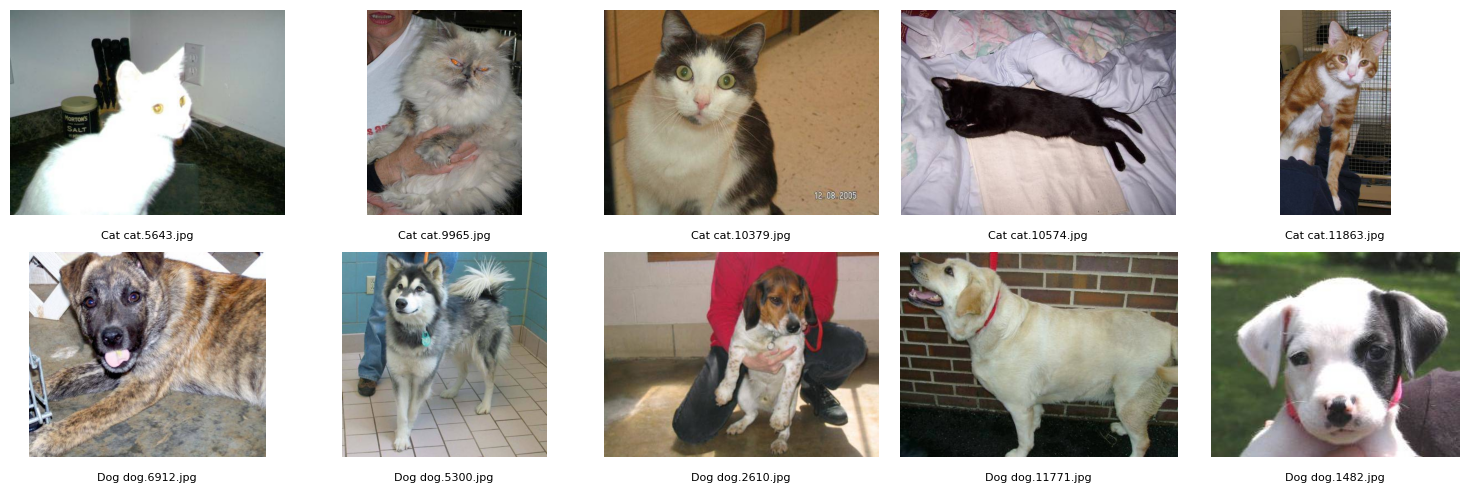

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

# Define paths for cats and dogs folders
cats_dir = '/content/cat-dog-dataset/train/cats'
dogs_dir = '/content/cat-dog-dataset/train/dogs'

# Get a list of image paths from both categories
cat_images = [os.path.join(cats_dir, img) for img in os.listdir(cats_dir) if img.endswith(('.png', '.jpg', '.jpeg'))]
dog_images = [os.path.join(dogs_dir, img) for img in os.listdir(dogs_dir) if img.endswith(('.png', '.jpg', '.jpeg'))]

# Randomly select 5 images from each category
sample_cat_images = random.sample(cat_images, 5)
sample_dog_images = random.sample(dog_images, 5)

# Plot sample images from cats
plt.figure(figsize=(15, 5))
for i, img_path in enumerate(sample_cat_images):
    plt.subplot(2, 5, i + 1)
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.axis('off')
    # Display the filename below the image
    plt.text(0.5, -0.1, f"Cat {os.path.basename(img_path)}", ha='center', va='center', fontsize=8, transform=plt.gca().transAxes)

# Plot sample images from dogs
for i, img_path in enumerate(sample_dog_images):
    plt.subplot(2, 5, i + 6)
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.axis('off')
    # Display the filename below the image
    plt.text(0.5, -0.1, f"Dog {os.path.basename(img_path)}", ha='center', va='center', fontsize=8, transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()


In [4]:
#  Import necessary libraries
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50  # Import ResNet50 model
from tensorflow.keras import layers, models  # Import layers and models


In [5]:
# Preprocess the Data
# Define paths to the training and test data
train_dir = '/content/cat-dog-dataset/train'
test_dir = '/content/cat-dog-dataset/test'

# Set image size to match ResNet50 input dimensions
image_size = (224, 224)

# ImageDataGenerator for preprocessing and augmentation for the training data
train_datagen = ImageDataGenerator(
    rescale=1./255,               # Normalize pixel values
    rotation_range=40,           # Random rotations
    width_shift_range=0.2,       # Random horizontal shifts
    height_shift_range=0.2,      # Random vertical shifts
    shear_range=0.2,             # Shear transformations
    zoom_range=0.2,              # Random zooms
    horizontal_flip=True,        # Random horizontal flips
    fill_mode='nearest'          # Fill pixels after transformations
)

# ImageDataGenerator for preprocessing the test data (no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow data from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=32,
    class_mode='binary'  # For binary classification (cat vs dog)
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=32,
    class_mode='binary'
)


Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [6]:
# Define the Model
# Load the ResNet50 model with ImageNet weights (excluding the top layer)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model to prevent training of the pre-trained layers
base_model.trainable = False

# Build the model on top of ResNet50
model = models.Sequential([
    base_model,  # Add ResNet50 as the base model
    layers.GlobalAveragePooling2D(),  # Pooling layer to reduce output size
    layers.Dense(1024, activation='relu'),  # Fully connected layer
    layers.Dense(1, activation='sigmoid')  # Output layer for binary classification (cat vs dog)
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           1,025 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,686,913 (97.99 MB)

 Trainable params: 2,099,201 (8.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [7]:
#  Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,  # Training for 10 epochs
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


625/625 ━━━━━━━━━━━━━━━━━━━━ 292s 443ms/step - accuracy: 0.5516 - loss: 0.7421 - val_accuracy: 0.5104 - val_loss: 0.7131
Epoch 2/10


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.3750 - val_loss: 0.6546
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 309s 437ms/step - accuracy: 0.5823 - loss: 0.6732 - val_accuracy: 0.6306 - val_loss: 0.6446
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 82us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6250 - val_loss: 0.6299
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 275s 435ms/step - accuracy: 0.5992 - loss: 0.6647 - val_accuracy: 0.6320 - val_loss: 0.6454
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 71us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7500 - val_loss: 0.5911
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 323s 438ms/step - accuracy: 0.6077 - loss: 0.6621 - val_accuracy: 0.5837 - val_loss: 0.6612
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 0.7411
Epoch 9/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 314s 435ms/step - accuracy: 

In [8]:
# Step 6: Save the trained model
model_save_path = '/content/drive/My Drive/cat_dog_classifier.h5'
model.save(model_save_path)

print(f"Model saved to: {model_save_path}")

Model saved to: /content/drive/My Drive/cat_dog_classifier.h5


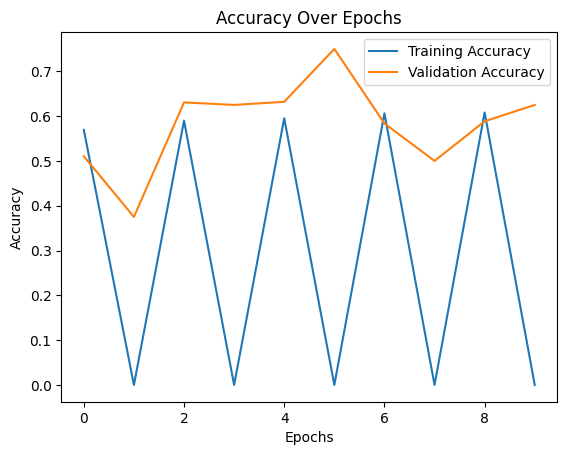

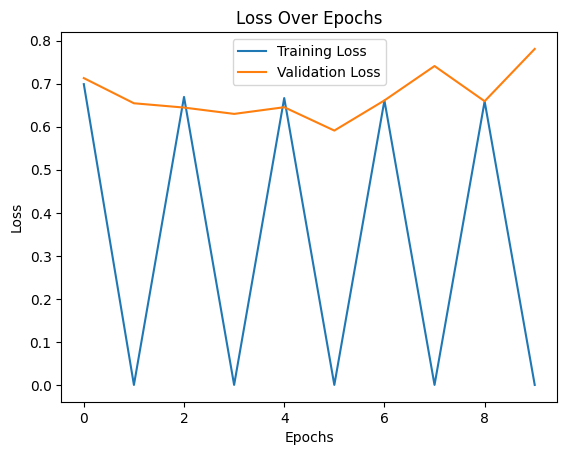

In [9]:
# Step 7: Visualize training history
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
